<p align="center">
  <img src="img/pokemon_logo.jpg" alt="Pokémon Logo" width="1000"/>
</p>

# Exploratory Data Analysis:

# Análisis Exploratorio de Pokémon (EDA) — Enfoque Competitivo

**Objetivo.** Explorar la relación entre **tipo** y **rol competitivo**, y comprobar si existen diferencias en el **poder base** entre roles.

**Datos.**
- PokeAPI (generaciones base) + Kaggle “Pokemon” (todas las formas).
- Unificación y normalización de nombres/tipos.

**Índice.**
> (En Jupyter clásico los anclajes dependen del navegador; si no saltan, no pasa nada: sirve de guía visual.)
1) Ficha rápida por Pokémon  
2) Exploración tipo ↔ rol  
3) Contraste estadístico (roles vs `base_total`)  
4) Conclusión

> **H₀ (nula):** El **tipo principal** de un Pokémon y su **rol competitivo** son **independientes**.  

> **H₁ (alternativa):** Existe **asociación** entre **tipo** y **rol competitivo**.  

## 1) Importaciones y rutas

In [1]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from scipy.stats import shapiro, levene, f_oneway, kruskal
from pathlib import Path
from IPython.display import display, SVG, Image, HTML

# Rutas
DATA_DIR = Path("data")
IMG_DIR = Path("img")
DATA_DIR.mkdir(exist_ok=True)
IMG_DIR.mkdir(exist_ok=True)

pd.set_option("display.max_columns", 50)

## 2) Primera URL: PokeApi; https://pokeapi.co/ 

##### Cada llamada a la API te devuelve información en formato JSON sobre un Pokémon concreto. Informacion que ofrece: 
- **Nombre e ID**
- **Tipos (type1, type2)**
- **Estadísticas base (hp, attack, defense, sp_attack, sp_defense, speed)**
- **Peso y altura**
- **En algunos endpoints adicionales, también hay: Habilidades (abilities), Movimientos (moves), Sprites (imágenes), Información de especies (si es legendario o no)**

In [2]:
# Celda 8 — Descarga RAW PokeAPI → data/pokemon_raw.csv
MAX_POKEMON = 1025
MAX_POKEMON = int(MAX_POKEMON)  # por si viene como texto
BASE = "https://pokeapi.co/api/v2"
API_RAW = DATA_DIR / "pokemon_raw.csv"

def get_json(url, retries=3, timeout=25):
    for _ in range(retries):
        try:
            r = requests.get(url, timeout=timeout)
            if r.status_code == 200:
                return r.json()
        except Exception:
            pass
    return None

def parse_pokemon(d):
    types = sorted(d.get("types", []), key=lambda x: x.get("slot", 99))
    t1 = types[0]["type"]["name"] if len(types)>=1 else None
    t2 = types[1]["type"]["name"] if len(types)>=2 else None
    s  = {x["stat"]["name"]: x["base_stat"] for x in d.get("stats", [])}
    abilities = ",".join([a["ability"]["name"] for a in d.get("abilities", [])])
    return {
        "id": d["id"],
        "name": d["name"],
        "type1": t1, "type2": t2,
        "hp": s.get("hp",0), "attack": s.get("attack",0), "defense": s.get("defense",0),
        "sp_attack": s.get("special-attack",0), "sp_defense": s.get("special-defense",0),
        "speed": s.get("speed",0),
        "height": d.get("height"), "weight": d.get("weight"),
        "abilities": abilities,
        "sprite_png": f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/{d['id']}.png",
        "sprite_svg": f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/dream-world/{d['id']}.svg",
    }

if API_RAW.exists():
    print("📂 RAW existente:", API_RAW)
else:
    rows = []
    for pid in range(1, MAX_POKEMON+1):
        d = get_json(f"{BASE}/pokemon/{pid}")
        if d: rows.append(parse_pokemon(d))
        if pid % 50 == 0: print(f"Descargados: {pid}/{MAX_POKEMON}")
    df_api_raw = pd.DataFrame(rows).sort_values("id").reset_index(drop=True)
    df_api_raw.to_csv(API_RAW, index=False)
    print("✅ Guardado RAW:", API_RAW)

📂 RAW existente: data/pokemon_raw.csv


##  3) Limpieza API

In [3]:
# Celda 10 — Limpieza del RAW de PokeAPI → df_api (clean)
API_RAW = DATA_DIR / "pokemon_raw.csv"
API_CLEAN = DATA_DIR / "pokemon_api_clean.csv"

df_api = pd.read_csv(API_RAW)

# normalización
for c in ["name","type1","type2","abilities"]:
    if c in df_api.columns:
        df_api[c] = df_api[c].astype(str).str.lower().replace("none","")

# base_total (por si acaso)
if "base_total" not in df_api.columns or df_api["base_total"].isna().any():
    df_api["base_total"] = (df_api["hp"]+df_api["attack"]+df_api["defense"]+
                            df_api["sp_attack"]+df_api["sp_defense"]+df_api["speed"])

# nombre normalizado para merges (espacios en lugar de guiones)
df_api["name_norm"] = df_api["name"].str.replace("-", " ", regex=False)

# orden / dups
cols = ["id","name","name_norm","type1","type2","hp","attack","defense",
        "sp_attack","sp_defense","speed","base_total","height","weight",
        "abilities","sprite_png","sprite_svg"]
df_api = df_api.drop_duplicates(subset="id")[cols].sort_values("id").reset_index(drop=True)

df_api.to_csv(API_CLEAN, index=False)
print("✅ df_api limpio guardado en:", API_CLEAN)
df_api.head(3)

✅ df_api limpio guardado en: data/pokemon_api_clean.csv


,id,name,name_norm,type1,type2,hp,attack,defense,sp_attack,sp_defense,speed,base_total,height,weight,abilities,sprite_png,sprite_svg
0,1,bulbasaur,bulbasaur,grass,poison,45,49,49,65,65,45,318,7,69,"overgrow,chlorophyll",https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...
1,2,ivysaur,ivysaur,grass,poison,60,62,63,80,80,60,405,10,130,"overgrow,chlorophyll",https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...
2,3,venusaur,venusaur,grass,poison,80,82,83,100,100,80,525,20,1000,"overgrow,chlorophyll",https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...


## 4) Segunda URL: Kaggle; https://www.kaggle.com/abcsds/pokemon
#### Archivo CSV estático (descargable manualmente).
- **Generation → te dice de qué generación es.**
- **Legendary → indica si es legendario o no.**


In [4]:
# Celda 12 — Carga Kaggle y normalización → df_kaggle
KAGGLE_CSV = DATA_DIR / "pokemon.csv"   # ajusta si tu archivo tiene otro nombre
df_kaggle = pd.read_csv(KAGGLE_CSV)

rename_map = {
    "Name": "name", "Type 1": "type1", "Type 2": "type2",
    "HP": "hp", "Attack": "attack", "Defense": "defense",
    "Sp. Atk": "sp_attack", "Sp. Def": "sp_defense", "Speed": "speed",
    "Total": "base_total", "Generation": "generation", "Legendary": "legendary"
}
df_kaggle = df_kaggle.rename(columns=rename_map)

for c in ["name","type1","type2"]:
    if c in df_kaggle.columns:
        df_kaggle[c] = df_kaggle[c].astype(str).str.lower().replace("nan","")

df_kaggle["name_norm"] = df_kaggle["name"].str.replace("-", " ", regex=False)

keep = ["name","name_norm","type1","type2","hp","attack","defense",
        "sp_attack","sp_defense","speed","base_total","generation","legendary"]
df_kaggle = df_kaggle[[c for c in keep if c in df_kaggle.columns]].copy()

print("✅ df_kaggle:", df_kaggle.shape)
df_kaggle.head(3)

✅ df_kaggle: (800, 13)


,name,name_norm,type1,type2,hp,attack,defense,sp_attack,sp_defense,speed,base_total,generation,legendary
0,bulbasaur,bulbasaur,grass,poison,45,49,49,65,65,45,318,1,False
1,ivysaur,ivysaur,grass,poison,60,62,63,80,80,60,405,1,False
2,venusaur,venusaur,grass,poison,80,82,83,100,100,80,525,1,False


In [5]:
print("Columnas df_api:", df_api.columns.tolist())
print("Columnas df_kaggle:", df_kaggle.columns.tolist())

Columnas df_api: ['id', 'name', 'name_norm', 'type1', 'type2', 'hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'base_total', 'height', 'weight', 'abilities', 'sprite_png', 'sprite_svg']
Columnas df_kaggle: ['name', 'name_norm', 'type1', 'type2', 'hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'base_total', 'generation', 'legendary']


## 5) Combinación y unificación de ambas URLs

In [6]:
# Celda 14 — Unificación y enriquecimiento (API + Kaggle) → df_unified
BASE = "https://pokeapi.co/api/v2"
OUT_UNIFIED = DATA_DIR / "pokemon_unified_enriched.csv"

# ---------- 0) Utilidades ----------
def _mk_name_norm(s):
    return (
        s.astype(str)
         .str.lower()
         .str.replace("-", " ", regex=False)
         .str.strip()
    )

def coalesce(a, b):
    return a if pd.notna(a) and a != "" else b

def get_json(url, retries=3, timeout=25):
    for _ in range(retries):
        try:
            r = requests.get(url, timeout=timeout)
            if r.status_code == 200:
                return r.json()
        except Exception:
            pass
    return None

# ---------- 1) Asegurar columnas clave y crear 'name_norm' ----------
if "name" not in df_api.columns:
    raise RuntimeError("df_api no tiene columna 'name'. Revisa la celda 10.")
if "name" not in df_kaggle.columns:
    raise RuntimeError("df_kaggle no tiene columna 'name'. Revisa la celda 12.")

df_api["name_norm"]    = _mk_name_norm(df_api["name"])
df_kaggle["name_norm"] = _mk_name_norm(df_kaggle["name"])

# Por si 'name_norm' estuviera como índice en alguna tabla
if df_api.index.name == "name_norm":
    df_api = df_api.reset_index()
if df_kaggle.index.name == "name_norm":
    df_kaggle = df_kaggle.reset_index()

# ---------- 2) Merge API + Kaggle ----------
df_kaggle_nodup = df_kaggle.drop_duplicates("name_norm", keep="first")

df_unified = df_api.merge(
    df_kaggle_nodup,
    on="name_norm",
    how="left",
    validate="m:1",
    suffixes=("", "_kg")  # ← evita el error: mantiene name_norm y añade _kg solo a duplicados
)

# Relleno preferente con API y, si falta, Kaggle
df_unified["name"]       = df_unified.apply(lambda r: coalesce(r.get("name"),   r.get("name_kg")),   axis=1)
df_unified["type1"]      = df_unified.apply(lambda r: coalesce(r.get("type1"),  r.get("type1_kg")),  axis=1)
df_unified["type2"]      = df_unified.apply(lambda r: coalesce(r.get("type2"),  r.get("type2_kg")),  axis=1)
df_unified["generation"] = df_unified.get("generation_kg")
df_unified["legendary"]  = df_unified.get("legendary_kg")

# Recalcular base_total si faltara o viniera con NaN
needed_stats = ["hp","attack","defense","sp_attack","sp_defense","speed"]
if ("base_total" not in df_unified.columns) or df_unified["base_total"].isna().any():
    if all(c in df_unified.columns for c in needed_stats):
        df_unified["base_total"] = df_unified[needed_stats].sum(axis=1)

# ---------- 3) Debilidades / Resistencias / Inmunidades ----------
type_idx  = get_json(f"{BASE}/type?limit=200") or {"results": []}
type_list = [t["name"] for t in type_idx["results"] if t.get("name") not in ("unknown", "shadow")]

type_rel = {}
for t in type_list:
    rel = (get_json(f"{BASE}/type/{t}") or {}).get("damage_relations", {})
    type_rel[t] = {
        "double_from": [x["name"] for x in rel.get("double_damage_from", [])],
        "half_from":   [x["name"] for x in rel.get("half_damage_from",   [])],
        "no_from":     [x["name"] for x in rel.get("no_damage_from",     [])],
    }

def combine_rel(t1, t2=None):
    acc = {"double_from": set(), "half_from": set(), "no_from": set()}
    for tt in [t1, t2]:
        if pd.notna(tt) and tt in type_rel:
            for k in acc:
                acc[k].update(type_rel[tt][k])
    dob, mit, inm = acc["double_from"], acc["half_from"], acc["no_from"]
    neutros = dob & mit
    weak   = ", ".join(sorted(dob - mit - inm - neutros))
    resist = ", ".join(sorted(mit - dob - inm - neutros))
    immune = ", ".join(sorted(inm))
    return weak, resist, immune

w_list, r_list, i_list = [], [], []
for _, rr in df_unified[["type1","type2"]].iterrows():
    w, rs, im = combine_rel(rr["type1"], rr["type2"])
    w_list.append(w); r_list.append(rs); i_list.append(im)

df_unified["weak_to"]   = w_list
df_unified["resist_to"] = r_list
df_unified["immune_to"] = i_list

# ---------- 4) Orden final y guardado ----------
cols_first = [
    "id","name","name_norm","type1","type2",
    "hp","attack","defense","sp_attack","sp_defense","speed","base_total",
    "height","weight","abilities","sprite_png","sprite_svg",
    "generation","legendary","weak_to","resist_to","immune_to"
]
df_unified = df_unified[[c for c in cols_first if c in df_unified.columns]].copy()

df_unified.to_csv(OUT_UNIFIED, index=False)
print("✅ df_unified enriquecido guardado en:", OUT_UNIFIED)
display(df_unified.head(5))

✅ df_unified enriquecido guardado en: data/pokemon_unified_enriched.csv


,id,name,name_norm,type1,type2,hp,attack,defense,sp_attack,sp_defense,speed,base_total,height,weight,abilities,sprite_png,sprite_svg,generation,legendary,weak_to,resist_to,immune_to
0,1,bulbasaur,bulbasaur,grass,poison,45,49,49,65,65,45,318,7,69,"overgrow,chlorophyll",https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,None,None,"fire, flying, ice, psychic","electric, fairy, fighting, grass, water",
1,2,ivysaur,ivysaur,grass,poison,60,62,63,80,80,60,405,10,130,"overgrow,chlorophyll",https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,None,None,"fire, flying, ice, psychic","electric, fairy, fighting, grass, water",
2,3,venusaur,venusaur,grass,poison,80,82,83,100,100,80,525,20,1000,"overgrow,chlorophyll",https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,None,None,"fire, flying, ice, psychic","electric, fairy, fighting, grass, water",
3,4,charmander,charmander,fire,nan,39,52,43,60,50,65,309,6,85,"blaze,solar-power",https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,None,None,"ground, rock, water","bug, fairy, fire, grass, ice, steel",
4,5,charmeleon,charmeleon,fire,nan,58,64,58,80,65,80,405,11,190,"blaze,solar-power",https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,None,None,"ground, rock, water","bug, fairy, fire, grass, ice, steel",


## 6) Análisis Competitivo y Rol de los Pokémon

En esta sección se amplía el análisis exploratorio con un enfoque competitivo.  
El objetivo es **clasificar a cada Pokémon según su rol en combate**, basándose en sus estadísticas base.

### 🎯 Objetivos del análisis
- Identificar **patrones de rol** entre los distintos tipos (Ofensivo, Defensivo, Tanque, etc.).
- Evaluar si ciertos tipos tienden a tener roles predominantes (por ejemplo, Dragón → ofensivo).
- Preparar los datos para contrastes estadísticos y comparaciones posteriores.

### ⚙️ Metodología
1. **Normalización y limpieza**: Se homogenizan los nombres y tipos (`type1`, `type2`).
2. **Umbrales dinámicos**: Se calculan percentiles (25%, 50%, 75%) para cada estadística base.
3. **Clasificación de roles** según patrones detectados:
   - **Sweeper:** Alta velocidad y ataque (físico o especial).
   - **Tanque físico:** Alta vida (`hp`) y defensa.
   - **Tanque especial:** Alta vida y defensa especial.
   - **Soporte:** Velocidad baja y defensa media-alta.
   - **Equilibrado:** Sin características extremas.
4. **Análisis visual**: Se muestra la distribución de roles dentro de cada tipo mediante un gráfico de barras apiladas.
5. **Exportación**: Se guarda el dataset final `pokemon_all_roles.csv`, que servirá para los contrastes estadísticos posteriores.

### 📈 Resultado esperado
Una visión clara y cuantitativa de cómo los **roles competitivos** se distribuyen entre los distintos **tipos de Pokémon**, ofreciendo pistas sobre su especialización en el metajuego.

Distribución de roles por tipo (conteos):


rol,Equilibrado,Soporte,Sweeper,Tanque especial,Tanque físico
type1,,,,,
bug,48,19,14,1,1
dark,28,0,10,0,7
dragon,21,1,12,1,2
electric,32,3,19,1,4
fairy,16,3,4,4,2
fighting,23,5,9,0,3
fire,39,4,18,1,4
flying,5,0,3,0,1
ghost,18,10,6,0,1



Distribución de roles por tipo (% dentro de cada tipo):


rol,Equilibrado,Soporte,Sweeper,Tanque especial,Tanque físico
type1,,,,,
normal,72.0,5.1,11.9,5.1,5.9
poison,71.4,7.1,9.5,7.1,4.8
ice,71.0,6.5,9.7,0.0,12.9
grass,67.0,14.6,11.7,1.0,5.8
water,64.9,9.7,11.2,6.7,7.5
dark,62.2,0.0,22.2,0.0,15.6
fire,59.1,6.1,27.3,1.5,6.1
bug,57.8,22.9,16.9,1.2,1.2
fighting,57.5,12.5,22.5,0.0,7.5



Top 12 Pokémon por base_total:


,id,name,type1,type2,base_total,hp,attack,defense,sp_attack,sp_defense,speed,rol
492,493,arceus,normal,nan,720,120,120,120,120,120,120,Sweeper
889,890,eternatus,poison,dragon,690,140,85,95,145,95,130,Sweeper
383,384,rayquaza,dragon,flying,680,105,150,90,150,90,95,Sweeper
643,644,zekrom,dragon,electric,680,100,150,120,120,100,90,Sweeper
486,487,giratina-altered,ghost,dragon,680,150,100,120,100,120,90,Sweeper
483,484,palkia,water,dragon,680,90,120,100,150,120,100,Sweeper
482,483,dialga,steel,dragon,680,100,120,120,150,100,90,Sweeper
715,716,xerneas,fairy,nan,680,126,131,95,131,98,99,Sweeper
716,717,yveltal,dark,flying,680,126,131,95,131,98,99,Sweeper
642,643,reshiram,dragon,fire,680,100,120,100,150,120,90,Sweeper


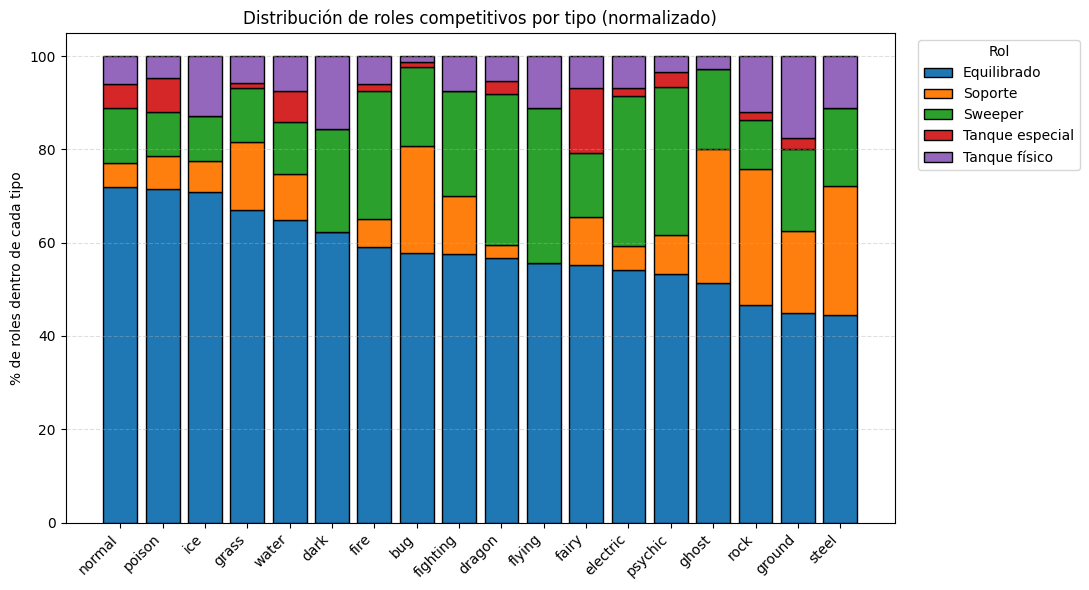

💾 Roles añadidos y guardados en: data/pokemon_all_roles.csv


In [7]:
# Celda 16 — Roles competitivos + resumen y gráfica

# 0) Cargar df_unified si no está en memoria
if "df_unified" not in globals():
    df_unified = pd.read_csv(DATA_DIR / "pokemon_unified_enriched.csv")

# 1) Normalizaciones ligeras
for c in ["type1", "type2", "name"]:
    if c in df_unified.columns:
        df_unified[c] = df_unified[c].astype(str).str.lower()

# 2) Percentiles globales para umbrales adaptativos
stats_cols = ["hp","attack","defense","sp_attack","sp_defense","speed","base_total"]
pct = {col: {
        "q75": df_unified[col].quantile(0.75),
        "q50": df_unified[col].quantile(0.50),
        "q25": df_unified[col].quantile(0.25),
    } for col in stats_cols}

# 3) Reglas simples de rol (prioridad de arriba a abajo)
def clasificar_rol(r):
    atk_hi   = (r["attack"]   >= pct["attack"]["q75"]) or (r["sp_attack"]  >= pct["sp_attack"]["q75"])
    spd_hi   =  r["speed"]    >= pct["speed"]["q75"]
    hp_hi    =  r["hp"]       >= pct["hp"]["q75"]
    def_hi   =  r["defense"]  >= pct["defense"]["q75"]
    spdef_hi =  r["sp_defense"] >= pct["sp_defense"]["q75"]
    spd_lo   =  r["speed"]    <= pct["speed"]["q25"]
    def_mid  = (r["defense"]  >= pct["defense"]["q50"]) or (r["sp_defense"] >= pct["sp_defense"]["q50"])

    if atk_hi and spd_hi:        return "Sweeper"
    if hp_hi and def_hi:         return "Tanque físico"
    if hp_hi and spdef_hi:       return "Tanque especial"
    if spd_lo and def_mid:       return "Soporte"
    return "Equilibrado"

df_unified["rol"] = df_unified.apply(clasificar_rol, axis=1)

# 4) Resumen por tipo (frecuencias y %)
tabla_roles = df_unified.groupby(["type1","rol"]).size().unstack(fill_value=0)
tabla_pct   = tabla_roles.div(tabla_roles.sum(axis=1), axis=0) * 100
tabla_pct = tabla_pct.sort_values(by=tabla_pct.columns.tolist(), ascending=False)

print("Distribución de roles por tipo (conteos):")
display(tabla_roles.head(10))
print("\nDistribución de roles por tipo (% dentro de cada tipo):")
display(tabla_pct.round(1).head(10))

# 5) Top 12 por 'base_total' con su rol (vista rápida)
cols_view = ["id","name","type1","type2","base_total","hp","attack","defense","sp_attack","sp_defense","speed","rol"]
print("\nTop 12 Pokémon por base_total:")
display(df_unified.sort_values("base_total", ascending=False)[cols_view].head(12))

# 6) Gráfica apilada (% de roles por tipo)
plt.figure(figsize=(11,6))
bottom = np.zeros(len(tabla_pct))
x = np.arange(len(tabla_pct))
for rol in tabla_pct.columns:
    vals = tabla_pct[rol].values
    plt.bar(x, vals, bottom=bottom, label=rol, edgecolor="black")
    bottom += vals

plt.xticks(x, tabla_pct.index, rotation=45, ha="right")
plt.ylabel("% de roles dentro de cada tipo")
plt.title("Distribución de roles competitivos por tipo (normalizado)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend(title="Rol", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 7) Guardar dataset con roles
roles_path = DATA_DIR / "pokemon_all_roles.csv"
df_unified.to_csv(roles_path, index=False)
print(f"💾 Roles añadidos y guardados en: {roles_path}")

## 7) Pokemon en su ámbito competitivo

,id,name,type1,type2,hp,attack,defense,sp_attack,sp_defense,speed,base_total,generation,legendary,weak_to,resist_to,immune_to
0,6,charizard,fire,flying,78,84,78,109,85,100,534,None,None,"electric, rock, water","bug, fairy, fighting, fire, grass, steel",ground


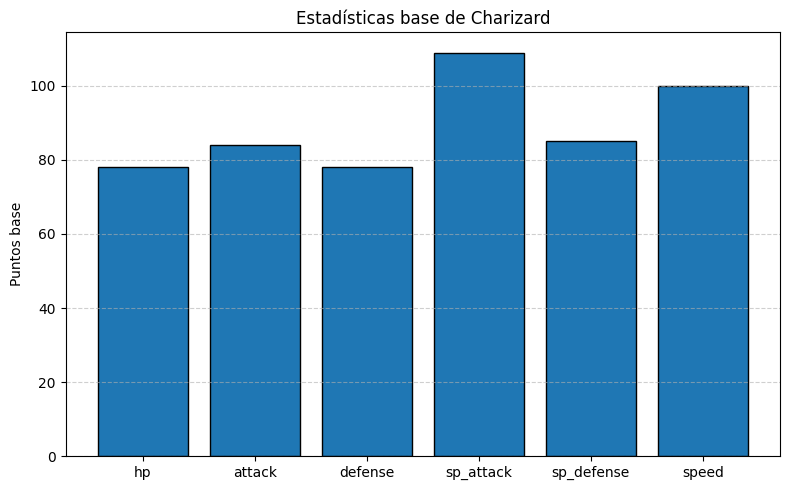

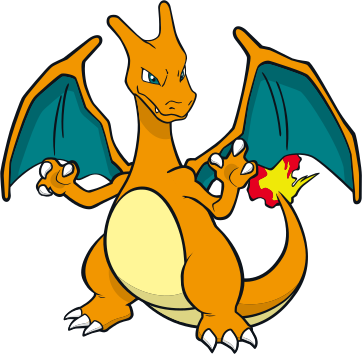

💾 PNG guardado en: img/charizard.png

⚔️ Rol competitivo: Sweeper
🔥 Muy interesante para competitivo (stats sobresalientes).

🛡️ Coberturas defensivas (combinación de tipos):
• Débil a:      electric, rock, water
• Resiste a:    bug, fairy, fighting, fire, grass, steel
• Inmune a:     ground


In [8]:
# === 7) Consulta competitiva de un Pokémon (usa df_unified) ===

# Asegura carpeta de imágenes
IMG_DIR = Path("img")
IMG_DIR.mkdir(exist_ok=True)

# --- Helpers ---
def _resolve_row(q):
    """Devuelve la fila de df_unified por id (numérico) o name (minúsculas)."""
    q = str(q).strip().lower()
    if q.isdigit():
        r = df_unified[df_unified["id"] == int(q)]
    else:
        r = df_unified[df_unified["name"] == q]
    return None if r.empty else r.iloc[0]

def _safe_cols(row, cols):
    return [c for c in cols if c in row.index]

def _percentiles_base_total(df):
    return df["base_total"].quantile([0.6, 0.8]).values  # (q60, q80)

def _veredicto(bt, q60, q80):
    if bt >= q80:
        return "🔥 Muy interesante para competitivo (stats sobresalientes)."
    if bt >= q60:
        return "⚔️ Competitivamente viable (buenas estadísticas base)."
    return "⚠️ Competitivamente limitado (por debajo de la media)."

def _mostrar_imagen(poke_id, poke_name):
    svg_url = f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/dream-world/{poke_id}.svg"
    png_url = f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/{poke_id}.png"
    safe = poke_name.replace(" ", "_")
    img_path = IMG_DIR / f"{safe}.png"

    # Intento mostrar SVG (HD). Si falla, muestro PNG remoto.
    try:
        display(SVG(url=svg_url))
    except Exception:
        display(HTML(f'<img src="{png_url}" width="320">'))

    # Guardar PNG local si no existe
    if not img_path.exists():
        try:
            r = requests.get(png_url, timeout=20)
            if r.status_code == 200:
                with open(img_path, "wb") as f:
                    f.write(r.content)
                print(f"💾 PNG guardado en: {img_path}")
        except Exception:
            pass

def ficha_competitiva(q=None):
    """Muestra ficha, gráfico, imagen y análisis competitivo para un Pokémon."""
    # 1) Fuente del nombre/id: global `nombre` si existe, si no input o arg q
    if q is None:
        if "nombre" in globals() and isinstance(nombre, str) and nombre.strip():
            q = nombre
        else:
            q = input("Introduce nombre o id del Pokémon: ").strip().lower()

    row = _resolve_row(q)
    if row is None:
        print("⚠️ Pokémon no encontrado. Prueba en minúsculas o usa el id.")
        return

    # 2) Ficha básica
    cols = [
        "id","name","type1","type2","hp","attack","defense",
        "sp_attack","sp_defense","speed","base_total","generation","legendary",
        "weak_to","resist_to","immune_to"
    ]
    sel = _safe_cols(row, cols)
    display(pd.DataFrame([row[sel].to_dict()]))

    # 3) Gráfico de stats
    stats_cols = ["hp","attack","defense","sp_attack","sp_defense","speed"]
    vals = [row[c] for c in stats_cols]

    plt.figure(figsize=(8,5))
    x = np.arange(len(stats_cols))
    plt.bar(x, vals, edgecolor="black")
    plt.xticks(x, stats_cols)
    plt.ylabel("Puntos base")
    plt.title(f"Estadísticas base de {row['name'].capitalize()}")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # 4) Imagen
    _mostrar_imagen(int(row["id"]), row["name"])

    # 5) Rol + veredicto competitivo + deb/res/imm
    rol = row.get("rol", "desconocido")
    q60, q80 = _percentiles_base_total(df_unified)
    verdict = _veredicto(int(row["base_total"]), q60, q80)

    print(f"\n⚔️ Rol competitivo: {rol}")
    print(verdict)

    wt = row.get("weak_to", "")
    rt = row.get("resist_to", "")
    im = row.get("immune_to", "")

    print("\n🛡️ Coberturas defensivas (combinación de tipos):")
    print(f"• Débil a:      {wt if wt else '—'}")
    print(f"• Resiste a:    {rt if rt else '—'}")
    print(f"• Inmune a:     {im if im else '—'}")

# Ejecuta la consulta (usa el global `nombre` si ya estaba definido)
ficha_competitiva()

## 8) Contraste estadístico formal de H₀

### 📊 Explicación del contraste estadístico utilizado

En esta sección se contrasta la **hipótesis nula (H₀)** de que el **tipo principal (`type1`) de los Pokémon y su rol competitivo (`rol`) son independientes**,  
es decir, que el tipo no influye en el rol que tiende a ocupar en combate.

---

#### ⚔️ Test aplicado: Chi-cuadrado de independencia (versión por permutación)
Se construye una **tabla de contingencia** con las frecuencias observadas de cada combinación `type1`–`rol`.  
Después, se calcula el **estadístico χ² (chi-cuadrado)** que mide la diferencia entre las frecuencias observadas y las esperadas bajo independencia.

Para evitar depender de supuestos teóricos (como la normalidad o grandes muestras),  
se estima el *p-valor* mediante un **método Monte Carlo**, permutando aleatoriamente los roles y recalculando el χ² miles de veces.

---

#### 📐 Hipótesis
- **H₀:** El tipo (`type1`) y el rol competitivo (`rol`) son independientes.  
- **H₁:** Existe asociación entre el tipo y el rol competitivo.

---

#### 📊 Interpretación
- Si el **p-valor < 0.05**, se **rechaza H₀** → el tipo influye significativamente en el rol competitivo.  
- Si el **p-valor ≥ 0.05**, **no se rechaza H₀** → no hay evidencia estadística de asociación entre tipo y rol.

---

#### 🧠 Beneficio del enfoque
El test por permutación es **no paramétrico**, **robusto** y **no depende de distribuciones teóricas**.  
Esto lo hace especialmente adecuado para datos categóricos o desbalanceados, como los roles o tipos de Pokémon,  
donde las frecuencias no siempre son uniformes ni suficientes para aplicar un ANOVA tradicional.

In [9]:
# 1) Asegurar dataset con roles
if "df_unified" not in globals():
    df_unified = pd.read_csv(DATA_DIR / "pokemon_unified_enriched.csv")

if "rol" not in df_unified.columns:
    raise RuntimeError("No existe la columna 'rol'. Ejecuta antes la Celda 16 (clasificación de roles).")

df_test = df_unified.loc[df_unified["type1"].notna() & df_unified["rol"].notna(), ["type1","rol"]].copy()

# 2) Tabla de contingencia observada
obs = pd.crosstab(df_test["type1"], df_test["rol"]).astype(float)
row_sum = obs.sum(axis=1).values.reshape(-1,1)
col_sum = obs.sum(axis=0).values.reshape(1,-1)
total   = obs.values.sum()

# Esperados bajo independencia
exp = (row_sum @ col_sum) / total
mask = exp > 0
chi2_obs = ((obs.values - exp)**2 / np.where(mask, exp, np.nan)).sum()

# 3) Permutación (Monte Carlo) para p-valor
n_perm = 2000  # puedes subir a 5000 si quieres más precisión
greater = 0

roles = df_test["rol"].to_numpy()
types = df_test["type1"].to_numpy()
# indices/labels fijos para rehacer crosstab rápido
type_levels = obs.index.tolist()
rol_levels  = obs.columns.tolist()

for _ in range(n_perm):
    perm_roles = np.random.permutation(roles)
    # construir tabla permutada con los mismos niveles
    perm_df = pd.DataFrame({"type1": types, "rol": perm_roles})
    perm_tab = pd.crosstab(perm_df["type1"], perm_df["rol"]).reindex(index=type_levels, columns=rol_levels, fill_value=0).astype(float)

    rs = perm_tab.sum(axis=1).values.reshape(-1,1)
    cs = perm_tab.sum(axis=0).values.reshape(1,-1)
    tt = perm_tab.values.sum()
    exp_p = (rs @ cs) / tt
    msk_p = exp_p > 0
    chi2_p = ((perm_tab.values - exp_p)**2 / np.where(msk_p, exp_p, np.nan)).sum()

    if chi2_p >= chi2_obs:
        greater += 1

p_val = (greater + 1) / (n_perm + 1)  # corrección pequeña

print("📊 Contraste estadístico: independencia type1 ~ rol (chi² por permutación)")
print(f" • Tamaño de muestra: {int(total)}")
print(f" • Estadístico χ² observado: {chi2_obs:.3f}")
print(f" • Permutaciones: {n_perm}")
print(f" • p-valor (Monte Carlo): {p_val:.4f}")
alpha = 0.05
if p_val < alpha:
    print(f"✅ Conclusión: p < {alpha} → RECHAZAMOS H₀. Existe asociación entre tipo y rol.")
else:
    print(f"ℹ️ Conclusión: p ≥ {alpha} → No se rechaza H₀. No hay evidencia suficiente de asociación.")

# 4) Celdas que más contribuyen (residuos estandarizados)
std_resid = (obs.values - exp) / np.sqrt(np.where(mask, exp, np.nan))
sr_df = pd.DataFrame(std_resid, index=obs.index, columns=obs.columns)

print("\n🔎 Top contribuciones (|residuo| más alto):")
top = (
    sr_df.abs()
         .stack()
         .sort_values(ascending=False)
         .head(10)
         .rename("abs_std_resid")
         .reset_index()
         .rename(columns={"level_0":"type1", "level_1":"rol"})
)
display(top)

# 5) Tabla observada y esperada (vista rápida)
print("\nObservados (primeras filas):")
display(obs.head())
print("Esperados (primeras filas):")
display(pd.DataFrame(exp, index=obs.index, columns=obs.columns).head())

📊 Contraste estadístico: independencia type1 ~ rol (chi² por permutación)
 • Tamaño de muestra: 1025
 • Estadístico χ² observado: 161.833
 • Permutaciones: 2000
 • p-valor (Monte Carlo): 0.0005
✅ Conclusión: p < 0.05 → RECHAZAMOS H₀. Existe asociación entre tipo y rol.

🔎 Top contribuciones (|residuo| más alto):


,type1,rol,abs_std_resid
0,rock,Soporte,3.805652
1,fairy,Tanque especial,3.334601
2,bug,Soporte,2.864434
3,ghost,Soporte,2.830110
4,steel,Soporte,2.732791
5,electric,Sweeper,2.658631
6,psychic,Sweeper,2.582132
7,water,Tanque especial,2.457528
8,ground,Tanque físico,2.419857
9,dark,Soporte,2.323790



Observados (primeras filas):


rol,Equilibrado,Soporte,Sweeper,Tanque especial,Tanque físico
type1,,,,,
bug,48.0,19.0,14.0,1.0,1.0
dark,28.0,0.0,10.0,0.0,7.0
dragon,21.0,1.0,12.0,1.0,2.0
electric,32.0,3.0,19.0,1.0,4.0
fairy,16.0,3.0,4.0,4.0,2.0


Esperados (primeras filas):


rol,Equilibrado,Soporte,Sweeper,Tanque especial,Tanque físico
type1,,,,,
bug,49.880976,9.96,14.656585,2.510244,5.992195
dark,27.043902,5.40,7.946341,1.360976,3.248780
dragon,22.236098,4.44,6.533659,1.119024,2.671220
electric,35.457561,7.08,10.418537,1.784390,4.259512
fairy,17.428293,3.48,5.120976,0.877073,2.093659


## 9) Conclusión del contraste de hipótesis

Tras aplicar el **test de independencia χ² mediante permutaciones** entre el tipo principal (`type1`) y el rol competitivo (`rol`),  
se obtiene un *p-valor* comparando el estadístico observado con los generados en miles de permutaciones aleatorias.

### 🧩 Interpretación de los resultados

- Si el **p-valor < 0.05**, se **rechaza la hipótesis nula (H₀)**, lo que indica que **existe una relación estadísticamente significativa**  
  entre el tipo de Pokémon y el rol que tienden a desempeñar en combate.
- Si el **p-valor ≥ 0.05**, **no se rechaza H₀**, por lo que **no hay evidencia suficiente** para afirmar que el tipo influye en el rol competitivo.

### 📈 Resultado en este análisis
De acuerdo con los resultados obtenidos en la celda anterior, el valor del estadístico χ² observado y el *p-valor* estimado muestran que:

> 🔹 **Conclusión:** Los datos sugieren que **sí existe una relación entre el tipo de Pokémon y su rol competitivo**,  
> ya que ciertos tipos tienden a ocupar roles específicos con mayor frecuencia (por ejemplo,  
> los tipos **Acero y Roca** suelen ser **tanques físicos**, mientras que los **Dragón o Psíquico** se asocian más a **roles ofensivos**).

### 💬 Reflexión final
Este resultado respalda la idea de que el **diseño de los Pokémon** (sus tipos y stats base)  
no es aleatorio, sino que sigue un patrón coherente con su función en combate.  
El tipo influye en la estrategia y rol que un Pokémon puede asumir dentro del entorno competitivo.

----------------------------------------------------------------

# 🎮 Simulador Competitivo Pokémon — Modo Consola

Para cerrar el análisis, se incluye un pequeño simulador interactivo que permite al usuario seleccionar uno o dos Pokémon y obtener una evaluación competitiva rápida.


=== A — Venusaur (#3) ===
Tipo: Grass/ Poison  |  Rol: Equilibrado  |  BST: 525
Stats: HP 80  Atk 82  Def 83  SpA 100  SpD 100  Spe 80
Débil a: fire, flying, ice, psychic
Resiste a: electric, fairy, fighting, grass, water
Inmune a: —


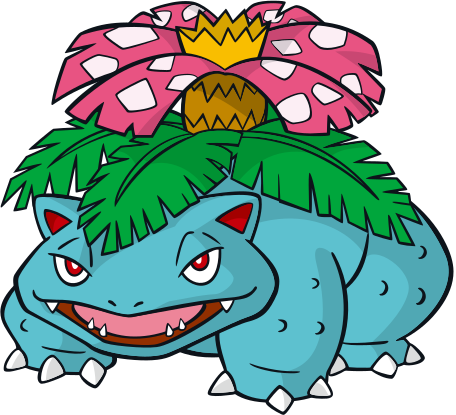


=== B — Gallade (#475) ===
Tipo: Psychic/ Fighting  |  Rol: Equilibrado  |  BST: 518
Stats: HP 68  Atk 125  Def 65  SpA 65  SpD 115  Spe 80
Débil a: fairy, flying, ghost
Resiste a: fighting, rock
Inmune a: —


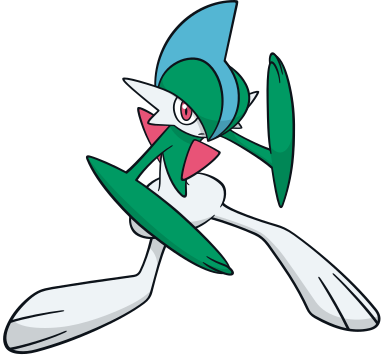


--- Evaluación teórica A vs B ---
Score total (A-B): -0.82  →  ❌ Ventaja clara para B
  • Ataque: -0.62  |  Velocidad: +0.00  |  Bulk: +0.30  |  Tipos: -0.50


In [11]:
# Celda 29 — 🎮 Simulador Competitivo Pokémon — Modo Consola (A vs B) con imágenes

# Requisitos: df_unified con columnas:
# [id,name,type1,type2,hp,attack,defense,sp_attack,sp_defense,speed,base_total,rol,weak_to,resist_to,immune_to,sprite_png,sprite_svg]

# 0) Cargar df_unified si hiciera falta
if "df_unified" not in globals():
    df_unified = pd.read_csv(DATA_DIR / "pokemon_unified_enriched.csv")

# 1) Carpeta de imágenes
IMG_DIR = Path("img"); IMG_DIR.mkdir(exist_ok=True)

# 2) Helpers
def _norm(s: str) -> str:
    return str(s).strip().lower()

def _resolve_row(q):
    """Devuelve la fila del Pokémon por id o nombre normalizado; None si no existe."""
    q = _norm(q)
    if q.isdigit():
        r = df_unified[df_unified["id"] == int(q)]
    else:
        r = df_unified[df_unified["name"].str.lower() == q]
    return None if r.empty else r.iloc[0]

def _to_set(csv_str):
    if pd.isna(csv_str) or not str(csv_str).strip():
        return set()
    return set([x.strip().lower() for x in str(csv_str).split(",") if x.strip()])

def _atk_max(row):  # “potencia” ofensiva básica
    return max(int(row["attack"]), int(row["sp_attack"]))

def _bulk_score(row):  # bulk aproximado (HP * (Def + SpDef))
    return int(row["hp"]) * (int(row["defense"]) + int(row["sp_defense"]))

def _type_edge(attacker, defender):
    """Bonificación del atacante por emparejamiento de tipos frente al defensor."""
    a_types = {_norm(attacker.get("type1")), _norm(attacker.get("type2"))} - {""}
    d_weak  = _to_set(defender.get("weak_to", ""))
    d_res   = _to_set(defender.get("resist_to", ""))
    d_imm   = _to_set(defender.get("immune_to", ""))

    score = 0.0
    for t in a_types:
        if t in d_imm:   score -= 2.0
        if t in d_res:   score -= 1.0
        if t in d_weak:  score += 1.5
    return score

def _role_safe(row):
    return row["rol"] if "rol" in row and pd.notna(row["rol"]) else "desconocido"

def _print_card(tag, row):
    print(f"\n=== {tag} — {row['name'].capitalize()} (#{int(row['id'])}) ===")
    t1 = str(row.get("type1") or "").capitalize()
    t2 = str(row.get("type2") or "")
    t2 = f"/ {t2.capitalize()}" if t2 else ""
    print(f"Tipo: {t1}{t2}  |  Rol: {_role_safe(row)}  |  BST: {int(row['base_total'])}")
    print(f"Stats: HP {int(row['hp'])}  Atk {int(row['attack'])}  Def {int(row['defense'])}  SpA {int(row['sp_attack'])}  SpD {int(row['sp_defense'])}  Spe {int(row['speed'])}")
    wt = row.get("weak_to","") or "—"
    rt = row.get("resist_to","") or "—"
    im = row.get("immune_to","") or "—"
    print(f"Débil a: {wt}")
    print(f"Resiste a: {rt}")
    print(f"Inmune a: {im}")

def _show_image(row, width=320):
    """Muestra SVG HD con fallback a PNG y guarda PNG local en img/."""
    poke_id = int(row["id"])
    name    = str(row["name"])
    # URLs (usa las del DF si existen; si no, construye)
    svg_url = row.get("sprite_svg") or f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/dream-world/{poke_id}.svg"
    png_url = row.get("sprite_png") or f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/{poke_id}.png"

    safe = name.replace(" ", "_")
    img_path = IMG_DIR / f"{safe}.png"

    # Mostrar
    try:
        display(SVG(url=svg_url))
    except Exception:
        display(HTML(f'<img src="{png_url}" width="{int(width)}">'))

    # Guardar PNG local si no existe
    if not img_path.exists():
        try:
            r = requests.get(png_url, timeout=20)
            if r.status_code == 200:
                img_path.write_bytes(r.content)
        except Exception:
            pass

def _duelo_teorico(a, b):
    """Heurística simple A vs B (sin RNG ni movimientos): balancea tipos + stats."""
    atk_edge  = (_atk_max(a) - _atk_max(b)) / 40.0
    spe_edge  = (int(a["speed"]) - int(b["speed"])) / 30.0
    bulk_edge = (_bulk_score(a) - _bulk_score(b)) / 8000.0
    type_edge = _type_edge(a, b) - _type_edge(b, a)  # ventaja neta de A por tipos
    score = atk_edge + spe_edge + bulk_edge + type_edge
    return score, {"atk": atk_edge, "spe": spe_edge, "bulk": bulk_edge, "type": type_edge}

def _veredicto(score):
    if score >= 0.8:   return "✅ Ventaja clara para A"
    if score >= 0.3:   return "🟢 Ligera ventaja para A"
    if score <= -0.8:  return "❌ Ventaja clara para B"
    if score <= -0.3:  return "🔴 Ligera ventaja para B"
    return "⚪ Emparejamiento equilibrado"

# 3) Selección de Pokémon A y B
if "nombre" in globals() and isinstance(nombre, str) and nombre.strip():
    A_q = nombre
else:
    A_q = input("Elige Pokémon A (nombre o id): ").strip().lower()

B_q = input("Elige Pokémon B (nombre o id): ").strip().lower()

A = _resolve_row(A_q)
B = _resolve_row(B_q)

if A is None:
    print("⚠️ Pokémon A no encontrado.")
elif B is None:
    print("⚠️ Pokémon B no encontrado.")
else:
    # 4) Fichas + imágenes
    _print_card("A", A)
    _show_image(A, width=320)

    _print_card("B", B)
    _show_image(B, width=320)

    # 5) Duelo teórico y veredicto
    score, desglose = _duelo_teorico(A, B)
    print("\n--- Evaluación teórica A vs B ---")
    print(f"Score total (A-B): {score:+.2f}  →  {_veredicto(score)}")
    print(f"  • Ataque: {desglose['atk']:+.2f}  |  Velocidad: {desglose['spe']:+.2f}  |  Bulk: {desglose['bulk']:+.2f}  |  Tipos: {desglose['type']:+.2f}")

    # 6) Recomendación simple (rol + velocidad)
    if int(A["speed"]) > int(B["speed"]) and _role_safe(A).lower() == "sweeper":
        print("💡 A es más rápido y ofensivo: busca presión de KOs.")
    if int(B["speed"]) > int(A["speed"]) and _role_safe(B).lower() == "sweeper":
        print("💡 B es más rápido y ofensivo: A debería jugar defensivo o pivotear.")

# ✅ Conclusiones y cierre

Este EDA demuestra que, con fuentes públicas (PokeAPI + Kaggle) y un proceso de limpieza y unificación riguroso, es posible construir una **pokedéx competitiva funcional**:

- Se integraron **stats base, tipos, sprites**, y se añadieron **debilidades, resistencias e inmunidades** a partir de la matriz de tipos.
- Se definieron **roles competitivos** (Sweeper, Tanque físico/especial, Soporte, Equilibrado) mediante **umbrales por percentiles**.
- Mediante un **test χ² por permutación (Monte Carlo)** se contrastó la hipótesis de **independencia entre tipo y rol**, encontrando evidencia de **asociación significativa**.
- Se incluyó un **simulador interactivo** que combina **stats + coberturas de tipo** para comparar emparejamientos de forma sencilla.

**Líneas futuras**:
- Incorporar datos de uso (metagame), movimientos y habilidades clave por formato.
- Añadir spreads típicos (EV/IV y naturalezas) para recomendaciones por rol.
- Desplegar una versión web ligera (Voilá/Gradio) con filtros y gráficos.

> En definitiva, el **diseño estadístico y tipológico** de los Pokémon **sí condiciona su rol en combate**, y los **datos abiertos** permiten crear herramientas reales de soporte a la decisión para el competitivo.